### 럭키백의 확률

럭키백은 구성품을 모른 채 먼저 구매하고 , 배송받은 다음에야 비로소 구성품을 알 수 있는 상품 <br>
마케팅 팀은 럭키백에 포함된 생선의 확률을 알려주는 방향으로 이벤트 수정안 내놓았다. <br>


그렇다면 어떻게 생선의 확률을 구할지가 문제이다. <br>
혹시 머신러닝으로 럭키백의 생선이 어떤 타깃에 속하는지 확률을 구할 수 있을까 ? <br>


럭키백에 들어갈 수 있는 생선은 7개이다. <br>
이 이벤트를 잘 마치려면 럭키백에 들어간 생선의 크기 , 무게 등이 주어졌을 때<br>
 7개 생선에 대한 확률을 출력해야 한다. <br>
이먼에는 길이 , 높이 , 두께 외에도 대각선 길이와 무게도 사용할 수 있다.

확률은 숫자니까 회귀 문제인가 ? 7개의 생선에 대한 분류 아닐까 ? <br>
k-최근접 이웃은 주변 이웃을 찾아주니까 이웃의 클래스 비율을 확률이라고 출력하면 되지 않을까 ?

예시 ) 주위 샘플 10개 중 사각형이 3개 , 삼각형이 5개 , 원이 2개이라면 , <br>
예상하려는 샘플이 사각형일 확률은 30% , 삼각형일 확률은 50% , 원일 확률은 25%

사이킷런의 k-최근접 이웃 분류기도 이와 동일한 방식으로 클래스 확률 계산하여 제공 <br> 

### 데이터 준비하기

3장처럼 판다스를 사용해 인터넷에서 직접 csv 데이터 읽어들여 데이터 준비 <br>
판다스의 read_csv() 함수로 CSV 파일을 데이터프레임으로 변환한 다음 <br>
head() 메서드로 처음 5개 행을 출력해 보자. 

In [1]:
import pandas as pd
fish = pd.read_csv('https://bit.ly/fish_csv_data')
fish.head()

,Species,Weight,Length,Diagonal,Height,Width
0,Bream,242.0,25.4,30.0,11.5200,4.0200
1,Bream,290.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,26.5,31.1,12.3778,4.6961
3,Bream,363.0,29.0,33.5,12.7300,4.4555
4,Bream,430.0,29.0,34.0,12.4440,5.1340


어떤 종류의 생선이 있는지 Species 열에서 고유한 값 추출해 보자. <br>
판다스의 unique() 함수 사용

In [2]:
print( pd.unique( fish[ 'Species' ] ) )

['Bream' 'Roach' 'Whitefish' 'Parkki' 'Perch' 'Pike' 'Smelt']


species 열에서 중복된 값은 하나로 간주하여 독립된 내용들만 출력

이 데이터프레임에서 Species 열을 타겟으로 만들고 , 나머지 5개 열은 입력 데이터로 사용하겠다. <br>

열을 선택하는 방법은 간단하다. <br>
데이터프레임에서 원하는 열을 리스트로 나열하면 된다. <br>
Species 열을 빼고 나머지 5개 열을 선택해 보자.

In [3]:
fish_input = fish[ [ 'Weight' , 'Length' , 'Diagonal' , 'Height' , 'Width' ] ].to_numpy()

데이터프레임에서 여러 열을 선택하면 새로운 데이터프레임이 반환된다. <br>
이를 to_numpy() 함수 사용하여 넘파이 배열로 바꾸어 fish_input 에 저장 <br>
잘 저장되었는지 처음 5개 행을 출력해 보자.

In [4]:
print( fish_input[ : 5] )

[[242.      25.4     30.      11.52     4.02  ]
 [290.      26.3     31.2     12.48     4.3056]
 [340.      26.5     31.1     12.3778   4.6961]
 [363.      29.      33.5     12.73     4.4555]
 [430.      29.      34.      12.444    5.134 ]]


이제 동일한 방식으로 타깃 데이터를 만들어보겠다. <br>

In [5]:
fish_target = fish[ 'Species' ].to_numpy()

2장에서 배웠듯이 머신러닝에서는 기본적으로 데이터 세트 2개가 필요하다.

In [6]:
from sklearn.model_selection import train_test_split

train_input , test_input , train_target , test_target = train_test_split(
  fish_input , fish_target , random_state = 42 )

그 다음 사이킷런의 StandardScaler 클래스를 사용해 <br> 
훈련 세트와 테스트 세트를 표준화 전처리화하겠다. <br>
여기에서도 훈련 세트의 통계 값으로 테스트 세트 변환해야 한다.

In [7]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit( train_input )
train_scaled = ss.transform( train_input )
test_scaled = ss.transform( test_input )

필요한 데이터를 모두 준비했다 이제 k-최근접 이웃 분류기로 <br>
테스트 세트에 들어 있는 확률을 예측해 보겠다.

### k-최근접 이웃 분류기의 확률 예측

2장에서 했던 것처럼 사이킷런의 KNeighborsClassifier 클래스 객체 만들고 <br>
훈련 세트로 모델을 훈련한 다음 훈련 세트와 테스트 세트의 점수 확인해 보겠다.<br>
최근접 이웃 개수인 k를 3으로 지정하여 사용한다.

In [8]:
from sklearn.neighbors import KNeighborsClassifier 
kn = KNeighborsClassifier( n_neighbors = 3 )
kn.fit( train_scaled , train_target )
print( kn.score( train_scaled , train_target ) )
print( kn.score( test_scaled , test_target ) )

0.8907563025210085
0.85


앞서 fish 데이터프레임에서 7개의 생선 있었음 <br>
타깃 데이터를 만들 때 fish[ 'Species ' ] 사용해 만들었기 때문에 <br>
훈련 세트와 테스트 세트의 타깃 데이터에도 7개의 생선 종류가 들어가 있다. <br>
이렇게 타깃 데이터에 2개 이상의 클래스가 포함된 문제를 **다중 분류**라 한다.

하지만 조금 전 코드에서 보듯이 <br>
2진 분류와 모델을 만들고 훈련하는 방식은 동일하다. <br>
이진 분류를 사용했을 때는 양성 클래스와 음성 클래스를 각각 1과 0으로 지정하여<br> 타깃 데이터를 만들었다.

다중 분류에서도 타깃값을 숫자로 바꾸어 입력할 수 있지만 사이킷런에서는 편리하게도 <br> 문자열로 된 타깃값을 그대로 사용할 수 있다.

이때 주의할 점은 타깃값을 그대로 사이킷런 모델에 전달하면 <br>
자동으로 알파벳 순으로 매겨진다 . 그러면 원래 순서와 달라진다. <br>
KNeighborsClassifier 에서 정렬된 타깃값은 classes_ 속성에 저장되어 있다.

In [9]:
print( kn.classes_ )

['Bream' 'Parkki' 'Perch' 'Pike' 'Roach' 'Smelt' 'Whitefish']


실제로 알파멧순으로 정렬된 형태를 보인다. <br>
predict() 메서드는 친절하게도 타깃값으로 예측을 출력한다. <br>
테스트 세트에 있는 처음 5개 샘플의 타깃값을 예측해 보겠다.

In [10]:
print( kn.predict( test_scaled[ : 5 ] ) )

['Perch' 'Smelt' 'Pike' 'Perch' 'Perch']


이 5개의 샘플에 대한 예측은 어떤 확률로 만들어졌을까 ? 사이킷런의 분류 모델은 <br> predict_proba() 메서드로 클래스별 확률값을 반환한다. <br>
테스트 세트에 있는 처음 5개의 샘플에 대한 확률을 출력해 보자. <br>
넘파이 round() 함수는 기본적으로 소수점 첫째 자리에서 반올림 <br>
decimals 매개변수로 유지할 소수점 아래 자릿수를 지정 가능

In [11]:
import numpy as np
proba = kn.predict_proba( test_scaled[ : 5 ] ) 
print( np.round( proba , decimals = 4 ) ) 

[[0.     0.     1.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     1.     0.    ]
 [0.     0.     0.     1.     0.     0.     0.    ]
 [0.     0.     0.6667 0.     0.3333 0.     0.    ]
 [0.     0.     0.6667 0.     0.3333 0.     0.    ]]


predict_proba 메서드의 출력 순서는 앞서 보였던 classes_ 속성과 같다. <br>
즉 첫번째 열이 "Bream"에 대한 확률 , 두 번째 열이 "Parkki"에 대한 확률 <br>
첫 다섯 개의 사례에 대한 각 클래스가 해당할 확률을 보여 준다.

이 모델이 게산한 확률이 가장 가까운 이웃의 비율이 맞는지 확인해 보자. <br>
네 번째 샘플의 최근접 이웃 클래스를 확인해 보자.

In [12]:
distances , indexes = kn.kneighbors( test_scaled[ 3 : 4 ] )
print( train_target[ indexes ] )

[['Roach' 'Perch' 'Perch']]


이 샘플의 이웃은 다섯번째 클래스인 "Roach" 가 1개이고 <br>
세 번째 클래스인 "Perch" 가 2개이다. <br>
따라서 다섯번째 클래스의 확률은 1/3 , 세번째 클래스에 대한 확률은 2/3 <br>
앞서 출력한 네 번째 샘플의 클래스 확률과 같다.

아주 쉽게 클래스 확률을 예측했지만 , 뭔가 좀 이상하다. <br>
잠시 생각해 보니 3개의 최근접 이웃을 사용하기 때문에 가능한 확률은 <br>
0/3 , 1/3 , 2/3 , 3/3 밖에 없다. 확률이라고 말하기에 좀 어색하다.<br>
뭔가 더 좋은 방법을 찾아야만 할 것 같다. 


### 로지스틱 회귀

로지스틱 회귀 : 이름은 회귀이지만 , **분류 모델** 이다. <br>
이 알고리즘은 선형 회귀와 동일하게 선형 방정식을 학습한다. <br>
예를 들면 다음과 같다.

z = ( a * Weight ) + ( b * Length ) + ( c * Diagonal ) + ( d * Height ) + ( e * Width ) + f <br>
여기에서 a , b , c , d , e 는 가중치 혹은 계수이다. <br>
특성은 늘어났지만 3장에서 다룬 다중 회귀를 위한 선형 방정식과 같다, <br>
z는 어떤 값도 가능하다. **하지만 확률이 되려면 0 ~ 1 사이의 값**이여야 한다.

z가 아주 큰 음수일 때 0 // 아주 큰 양수일 때 1 로<br>
바꿀 수는 없을까 ? <br>
**시그모이드 함수 ( 또는 로지스틱 함수 ) 사용**하면 가능

theta = 1 / ( 1 + e^(-x) ) => 시그모이드 함수 <br>
시그모이드 그래프 : 183페이지에 있다. <br>

z가 무한하게 큰 음수일 경우에 이 함수는 0에 가까워지고 , <br>
z가 무한하게 큰 양수일 경우에 이 함수는 1에 가까워진다. <br>
어떤 경우에도 0 ~ 1 사이에서 벗어날 수 없다.

넘파이를 사용하면 그래프 간단히 그릴 수 있다. <br>
-5와 5 사이에 0.1 간격으로 배열 z를 만든 다음 <br>
z 위치마다 시그모이드 함수 계산 <br>
지수 함수 계산은 np.exp() 함수 사용



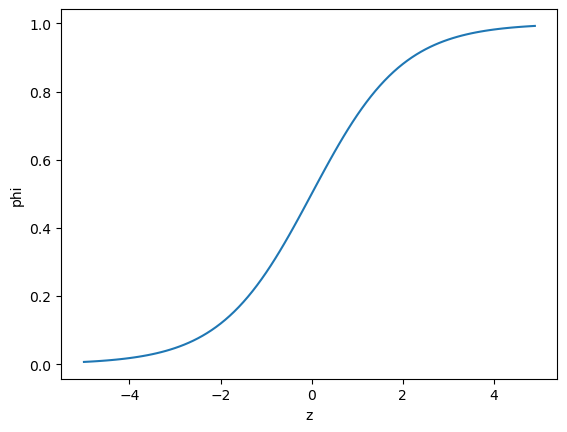

In [13]:
import numpy as np
import matplotlib.pyplot as plt
z = np.arange( -5 , 5 , 0.1 )
phi = 1 / ( 1 + np.exp( -z ) )
plt.plot( z , phi )
plt.xlabel( 'z' )
plt.ylabel( 'phi' )
plt.show()

그럼 로지스틱 회귀 모델을 마련해 보자. <br>
당연히 사이킷런에서는 로지스틱 회귀 모델인 LogisticRegression 클래스 마련되어 있음

훈련하기 전에 간단한 이진 분류를 수행해 보자. 이진 분류일 경우 <br>
시그모이드 함수의 출력이 0.5보다 크면 양성 클래스 <br>
0.5보다 작으면 음성 클래스이다. <br>
그럼 먼저 도미와 빙어 2개를 사용해서 이진 분류를 수행해 보자.

### 로지스택 회귀로 이진 분류 수행하기

넘파이 배열은 True , False 값을 전달하여 행을 선택할 수 있다. <br>
이를 **boolean indexing** 이라 한다. 간단한 예를 보자. <br>
다음과 같이 'A' 에서 'E' 까지 5개의 원소로 이루어진 배열이 있다. <br>
여기서 'A' 와 'C' 만 골라내려면 첫 번째와 세 번째 원소만 True이고 <br>
나머지 원소는 모두 False 인 배열만 전달하면 된다.

In [14]:
char_arr = np.array( [ 'A' , 'B' , 'C' , 'D' , 'E' ] )
print( char_arr[ [ True , False , True, False , False ] ] )

['A' 'C']


이와 같은 방식을 사용해 훈련세트에서는 도미와 빙어의 행만 골라내겠다. <br>
비교 연산자를 사용하면 도미와 빙어의 행을 모두 True로 만들 수 있다.

예를 들어 도미인 행을 골라내려면 , train_target =='Bream'과 같이 쓴다. <br>
이 비교식은 train_target 배열에서 Bream 인 것은 True이고 그 외에는 모두 False인 <br> 배열을 반환한다. 도미와 빙어에 대한 비교 결과를 비트 OR (|) 연산자 <br>
사용해 합치면 도미와 빙어에 대한 행만 골라낼 수 있다.

In [15]:
bream_smelt_indexes = ( train_target == 'Bream' ) | ( train_target == 'Smelt' )
train_bream_smelt = train_scaled[ bream_smelt_indexes ]
target_bream_smelt = train_target[ bream_smelt_indexes ]


bream_smelt_indexes 배열은 도미와 빙어일 경우 True이고 <br> 
그 외에는 모두 False 값이 들어가 있다. 따라서 이 배열을 사용해 <br>
train_scaled 와 train_target 배열에 불리언 인덱싱 적용하면 <br>
손쉽게 도미와 빙어 데이터만 골라낼 수 있다.

이제 이 데이터로 로지스틱 회귀 모델을 사용해 보자. <br>
LogisticRegression 클래스는 선형 모델이므로 sklearn.linear_model 패키지 아래 있다.

In [16]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit( train_bream_smelt , target_bream_smelt )

LogisticRegression()

훈련한 모델을 사용해 train_bream_smelt 에 있는 처음 5개 샘플을 예측해 보자 <br>

In [17]:
print( lr.predict( train_bream_smelt[ : 5] ) )

['Bream' 'Smelt' 'Bream' 'Bream' 'Bream']


두 번의 샘플을 제외하고는 모두 도미로 예측 <br>
KNeighborsClassifier와 마찬가지로 예측 확률은 predict_proba() 메소드에서 제공 <br> train_bream_smelt 에서 처음 5개 샘플의 예측 확률을 출력해 보자. 

In [18]:
print( lr.predict_proba( train_bream_smelt[ : 5 ] ) )

[[0.99759855 0.00240145]
 [0.02735183 0.97264817]
 [0.99486072 0.00513928]
 [0.98584202 0.01415798]
 [0.99767269 0.00232731]]


샘플마다 2개의 확률이 출력되었다. <br>
첫번째 열이 음성클래스에 대한 확률 , 두번째 열이 양성클래스에 대한 확률 <br>
그럼 Bream과 Smelt 중에 어떤 것이 양성 클래스인가 ? 

앞의 k-최근접 이웃 분류기에서 보았듯이 사이킷런은 타깃값을 알파벳순으로 정렬 <br> classes_ 속성에서 확인해 보자.

In [19]:
print( lr.classes_ )

['Bream' 'Smelt']


빙어가 양성 클래스이다. predict_proba() 메서드가 반환한 배열 값을 보면 <br>
두 번째 샘플만 양성 클래스인 빙어의 확률이 높다. 나머지는 모두 도미로 예측

로지스틱 회귀로 성공적인 이진 분류 수행 !! 그럼 선형 회귀에서처럼 <br>
로지스틱 회귀가 학습된 계수를 확인해 보자. 

In [20]:
print( lr.coef_ , lr.intercept_ )

[[-0.4037798  -0.57620209 -0.66280298 -1.01290277 -0.73168947]] [-2.16155132]


z = ( -0.404 * Weight ) + ( -0.576 * Length ) + ( -0.663 * Diagonal ) + ( -1.013 * Height ) + ( -0.732 * Width ) + ( -2.161 )

확실히 로지스틱 회귀는 선형 회귀와 매우 비슷하다. 그럼 LogisticRegression 모델로 <br> z값을 계산해 볼 수 있을까 ? 

가능하다. LogisticRegression 클래스는 decision_function() 메서드로 z값 출력가능
<br> train_bream_smelt의 처음 5개 샘플의 z값 출력해 보자.

In [21]:
decisions = lr.decision_function( train_bream_smelt[ : 5 ] )
print( decisions )

[-6.02927744  3.57123907 -5.26568906 -4.24321775 -6.0607117 ]


이 z값을 시그모이드 함수에 통과시키면 확률을 얻을 수 있다. <br>
다행히 파이썬의 scipy 라이브러리에도 시그모이드 함수가 있다. <br>
바로 expit() 메소드

np.exp() 함수를 사용해 분수 계산을 하는 것보다 훨씬 편리하고 안전하다, <br>
decision 배열의 값을 확률로 변환해 보자.

In [22]:
from scipy.special import expit
print( expit( decisions ) )

[0.00240145 0.97264817 0.00513928 0.01415798 0.00232731]


출력된 값을 보면 predict_proba() 메서드의 두번째 열의 값과 동일하다. <br>
즉 decision_function() 메소드는 양성 클래스에 대한 z값 반환

지금까지 한 활동 : <br>
이진 분류를 위해 2개의 생선 샘플을 골라내기 <br>
이를 사용해 로지스틱 회귀 모델 훈련 <br>
이진 분류일 경우 predict_proba() 메서드는 음성/양성 클래스 확률 출력 <br>
decision_function() 메서드는 양성 클래스 대한 z값 계산 <br>
coef_ ,intercept_ : 로지스틱 모델이 학습한 선형방정식 계수가 들어 있다. <br>

이제 2진 분류의 경험을 바탕으로 7개의 생선을 분류하는 다중 분류 문제로 넘어가 보자. 

### 로지스틱 회귀로 다중 분류 수행하기

다중 분류도 이진 분류와 크게 다르지 않다. <br>
여기에서도 LogisticRegression 클래스 사용해 7개의 생선을 분류하면서 <br>
이진 분류와의 차이점을 알아보겠다.

LogisticRegression 클래스는 기본적으로 반복적인 알고리즘 사용 <br>
max_iter 매개변수에서 반복횟수를 지정하며 디폴트값은 100 <br>
여기에 준비한 데이터셋을 사용해 모델을 훈련하면 반복 횟수가 부족하다는 경고 발생 <br> 충분하게 훈련시키기 위해 반복 횟수를 1000으로 늘린다.

또 LogisticRegression 은 기본적으로 릿지 회귀와 같이 계수의 제곱을 규제 <br>
이런 규제를 **L2규제** 라고 한다. <br> 
릿지 회귀에서는 alpha 매개변수로 규제의 양을 조절한다. <br>
alpha가 커지면 규제도 커진다. 

LogisticRegression 에서 규제를 제어하는 매개변수는 C이다. <br>
하지만 C는 alpha와 반대로 작을수록 규제가 커진다. <br>
C의 기본값은 1이다. 여기는 규제를 조금 완화하기 위해 20으로 늘렸다.

다음 코드는 LogisticRegression 클래스로 다중 분류 모델을 훈련하는 코드이다. <br>
7개의 생선 데이터가 모두 들어 있는 train_scaled 와 train_target 이용했다.

In [23]:
lr = LogisticRegression( C = 20 , max_iter = 1000 )
lr.fit( train_scaled , train_target )
print( lr.score( train_scaled , train_target ) )
print( lr.score( test_scaled , test_target ) )

0.9327731092436975
0.925


훈련 세트나 테스트 세트에 대한 점수가 높고 과대적합이나 과소적합으로 치우치지 않은듯 <br> 그럼 테스트의 처음 5개 샘플에 대한 예측을 출력해보자.

In [24]:
print( lr.predict( test_scaled[ : 5 ] ) )

['Perch' 'Smelt' 'Pike' 'Roach' 'Perch']


이번에는 테스트 세트의 처음 5개 샘플에 대한 예측 확률을 출력해 보겠다. <br>
출력을 간소화하기 위해 소수점 네번재 자리에서 반올림해서 출력하자.

In [25]:
proba = lr.predict_proba( test_scaled[ : 5 ] )
print( np.round( proba , decimals = 3 ) )

[[0.    0.014 0.841 0.    0.136 0.007 0.003]
 [0.    0.003 0.044 0.    0.007 0.946 0.   ]
 [0.    0.    0.034 0.935 0.015 0.016 0.   ]
 [0.011 0.034 0.306 0.007 0.567 0.    0.076]
 [0.    0.    0.904 0.002 0.089 0.002 0.001]]


속성에서 클래스 정보를 확인해 보자.

In [26]:
print( lr.classes_ )

['Bream' 'Parkki' 'Perch' 'Pike' 'Roach' 'Smelt' 'Whitefish']


이진 분류는 샘플마다 2개의 확률을 출력하고 , 다중 분류는 샘플마다 클래스 개수만큼 출력 <br>
이 중에서 가장 높은 확률이 예측 클래스가 된다. <br>

그럼 다중 분류일 경우 선형 방정식은 어떤 모습인가 ? <br>
coef_ 와 intercept_ 의 크기를 출력해 보자.

In [27]:
print( lr.coef_.shape , lr.intercept_.shape )

(7, 5) (7,)


이 데이터는 5개의 특성 사용 -> 열이 5개 <br>
그런데 행이 7개 , intercept_ 도 7개 : <br>
이진 분류에서 보았던 z를 7개나 계산한다는 의미 <br>

다중 분류는 클래스마다 z값을 하나씩 계산한다. 당연히 가장 높은 z값을 출력하는 클래스가 <br> 예측 클래스가 된다. <br>
확률 계산 방법은 ?? <br>

이진 분류에서는 시그모이드 함수를 사용해 z를 0 ~ 1 사이의 값으로 변환 <br>
다중 분류는 이와 달리 소프트맥스 함수 사용하여 **7개의 z값**을 확률로 변환

e_sum = e^z1 + e^z2 + ,,, + e^z7

s1 = e^z1 / e_sum , s2 = e^z2 / e_sum ,,, s7 = e^z7 / e_sum

s1에서 s7까지 모두 더하면 분자와 분모의 값이 같아지므로 1이 된다.

그럼 이진 분류에서처럼 decision_function() 메서드로 z1 ~ z7까지의 값을 구한 다음 <br>
소프트맥스 함수를 사용해 함수로 바꾸어 보겠다. <br>
먼저 테스트 세트의 처음 5개 샘플에 대한 z1 ~ z7의 값을 구해 보자.

In [28]:
decision = lr.decision_function( test_scaled[ : 5 ] )
print( np.round( decision , decimals = 2 ) )

[[ -6.5    1.03   5.16  -2.73   3.34   0.33  -0.63]
 [-10.86   1.93   4.77  -2.4    2.98   7.84  -4.26]
 [ -4.34  -6.23   3.17   6.49   2.36   2.42  -3.87]
 [ -0.68   0.45   2.65  -1.19   3.26  -5.75   1.26]
 [ -6.4   -1.99   5.82  -0.11   3.5   -0.11  -0.71]]


역시 사이파이는 소프트맥스 함수도 제공한다. scipy.special 아래에 softmax 함수를 임포트해 사용해 보자. <br>

In [29]:
from scipy.special import softmax

proba = softmax( decision , axis = 1 )
print( np.round( proba , decimals = 3 ) )

[[0.    0.014 0.841 0.    0.136 0.007 0.003]
 [0.    0.003 0.044 0.    0.007 0.946 0.   ]
 [0.    0.    0.034 0.935 0.015 0.016 0.   ]
 [0.011 0.034 0.306 0.007 0.567 0.    0.076]
 [0.    0.    0.904 0.002 0.089 0.002 0.001]]


softmax의 axis 매개변수는 소프트맥스를 계산할 축을 지정 <br>
여기에서는 axis = 1 로 지정하여 각 행 , 즉 각 샘플에 대해 소프트맥스 계산 <br>
만약 axis 매개변수를 지정하지 않으면 배열 전체에 대해 소프트맥스를 계산

출력 결과를 앞서 구한 proba 배열과 비교하면 , 결과가 정확히 일치한다.<br>
성공 !! 로지스틱 회귀를 사용해 7개의 생선에 대한 확률 예측하는 모델 훈련하였다.